In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
puzzle_data = pd.read_csv("../full_meta_clustered_singletag.tsv", sep='\t')

In [2]:
#Load the full dataset of puzzle attempts
attempts = pd.read_csv("/w/225/1/chess/tactics/glicko_user_tactics_problem.csv_00")

In [3]:
#Replace each 0 in the is_passed field with a -1 for calculating the total won - failed later
attempts['is_passed'] = attempts['is_passed'].replace(0, -1,regex=True)

<h2>Get Average User Success Sample Var in Actual Clusters</h2>

In [4]:
#Filter attempts to include only attempts by players who have played at least 100 games
attempts = attempts.loc[attempts['userGamesPlayed'] >= 1000]

In [5]:
#Join cluster labels to puzzles that were clustered 
attempts=pd.merge(attempts,puzzle_data[['tactics_problem_id','cluster','tag','rating']],on='tactics_problem_id', how='inner')

In [6]:
attempts.head()

,user_tactics_problem_id,user_hash,create_date,date,last_game_date,seconds,is_passed,correct_move_count,rating_change,tactics_problem_id,ratingUser,varianceUser,ratingProblem,varianceProblem,userGamesPlayed,cluster,tag,rating
0,3337015,3da90302d3d94216f2c06cc49efb2b122bee379c814392...,2008-05-11 10:17:09,2008-05-11,2008-05-11,8,-1,0,-44,30668,1829,36,1762,138,1002,4,Vulnerable King,1503
1,3337748,b7654c69d380e16dc133d59936f34b1318e353faa450fa...,2008-05-11 11:36:23,2008-05-11,2008-05-11,9,1,1,54,30668,1775,44,1819,128,1001,4,Vulnerable King,1503
2,3419396,7a348494ef7ba27a6fe2ed089ac84aca4a95ba77b95484...,2008-05-18 21:24:22,2008-05-18,2008-05-18,32,-1,0,-51,30668,1872,29,1831,68,1266,4,Vulnerable King,1503
3,3424342,9adee4e89a43a5f412bb4227433937655e99a11426c109...,2008-05-19 10:08:06,2008-05-19,2008-05-19,39,-1,0,-34,30668,1584,56,1861,65,1451,4,Vulnerable King,1503
4,3425081,709c6b9629f82206e2d0a980c2100253329e6c162a0c1b...,2008-05-19 11:16:20,2008-05-19,2008-05-19,6,-1,0,-12,30668,1639,47,1865,64,1227,4,Vulnerable King,1503


In [33]:
#Filter down to attempts for puzzles that are in the top 20 tags
'''
top_tags = ['Mate in 1', 'Mate in 2', 'Fork / Double Attack', 'Mate in 3+',
       'Hanging Piece', 'Mating Net', 'Pin', 'Vulnerable King',
       'Decoy / Deflection', 'Remove the Defender', 'Discovered Attack',
       'Defense', 'Endgame Tactics', 'Basic Checkmates', 'Back Rank',
       'Sacrifice', 'Pawn Promotion', 'Zwischenzug', 'Trapped Piece',
       'Attacking Castled King']
attempts = attempts.loc[attempts['tag'].isin(top_tags)]
'''

In [7]:
#Add expected success for each player using formula for ELO expected score here: 
#https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
''''
def add_success(row):
    prob_rating = row['ratingProblem']
    rating_user = row['ratingUser']
    rating_diff = prob_rating - rating_user
    return row['is_passed'] - 1/(1 + 10**(rating_diff/400))

attempts['success'] = attempts.progress_apply(lambda row: add_success(row),axis=1)
'''

"'\ndef add_success(row):\n    prob_rating = row['ratingProblem']\n    rating_user = row['ratingUser']\n    rating_diff = prob_rating - rating_user\n    return row['is_passed'] - 1/(1 + 10**(rating_diff/400))\n\nattempts['success'] = attempts.progress_apply(lambda row: add_success(row),axis=1)\n"

In [8]:
'''
#Get average user success for each cluster
opponent_ratings_total = attempts.groupby(['user_hash','cluster'])['ratingProblem'].sum()
num_cluster_games = attempts.groupby(['user_hash','cluster']).nunique()
user_cluster_averaged = attempts.groupby(['user_hash','cluster'])['success'].agg('mean')
#Get the variance of average cluster success and then take the average
avg_cluster_variance = user_cluster_averaged.var(level=0).agg('mean')
print(avg_cluster_variance)
'''

"\n#Get average user success for each cluster\nopponent_ratings_total = attempts.groupby(['user_hash','cluster'])['ratingProblem'].sum()\nnum_cluster_games = attempts.groupby(['user_hash','cluster']).nunique()\nuser_cluster_averaged = attempts.groupby(['user_hash','cluster'])['success'].agg('mean')\n#Get the variance of average cluster success and then take the average\navg_cluster_variance = user_cluster_averaged.var(level=0).agg('mean')\nprint(avg_cluster_variance)\n"

In [7]:
#Calculate performance rating per cluster per user
import time

def time_command(command,criteria):
    print('Running: ' + command)
    start = time.time()
    exec(command)
    print('Took: '  + str(time.time()-start))

def calc_user_performance(time=False,criteria='cluster'):
    commands = ["global opponent_ratings_total; opponent_ratings_total = attempts.groupby(['user_hash',criteria])['rating'].sum()",
                "global num_cluster_games; num_cluster_games = attempts.groupby(['user_hash',criteria])['user_hash'].count()",
                "global wins_plus_losses; wins_plus_losses = attempts.groupby(['user_hash',criteria])['is_passed'].sum()"]
    for command in commands:
        if time:
            time_command(command,criteria)
        else:
            exec(command)
    return (opponent_ratings_total + 400*wins_plus_losses)/num_cluster_games

In [8]:
#Get variance of performance rating per cluster per user
cluster_performance_user = calc_user_performance(True)
avg_cluster_variance = cluster_performance_user.var(level=0).agg('mean')
print(avg_cluster_variance)

Running: global opponent_ratings_total; opponent_ratings_total = attempts.groupby(['user_hash',criteria])['rating'].sum()
Took: 84.89727139472961
Running: global num_cluster_games; num_cluster_games = attempts.groupby(['user_hash',criteria])['user_hash'].count()
Took: 46.87016987800598
Running: global wins_plus_losses; wins_plus_losses = attempts.groupby(['user_hash',criteria])['is_passed'].sum()
Took: 36.659831047058105
108281.5993984598


In [24]:
tag_performance_user

user_hash                                                         tag                   
0006c3f3f05ee8a902169bf52833f36833580952eb90bd774328ad15d9c21fd2  Attacking Castled King    1196.648649
                                                                  Attacking f7/f2           1152.555556
                                                                  Back Rank                 1119.927273
                                                                  Basic Checkmates          1199.075000
                                                                  Clearance Sacrifice       1213.658537
                                                                  Decoy / Deflection        1076.720000
                                                                  Defense                   1212.897959
                                                                  Desperado                 1100.647059
                                                                  Discovered At

In [9]:
#Get variance of performance rating per tag per user
tag_performance_user = calc_user_performance(time=True,criteria='tag')
avg_tag_variance = tag_performance_user.var(level=0).agg('mean')
print(avg_tag_variance)

Running: global opponent_ratings_total; opponent_ratings_total = attempts.groupby(['user_hash',criteria])['rating'].sum()
Took: 39.78676199913025
Running: global num_cluster_games; num_cluster_games = attempts.groupby(['user_hash',criteria])['user_hash'].count()
Took: 53.713523387908936
Running: global wins_plus_losses; wins_plus_losses = attempts.groupby(['user_hash',criteria])['is_passed'].sum()
Took: 39.55060005187988
46236.27020432449


In [10]:
import matplotlib.pyplot as plt


def plot_tag_counts(series,label,filename):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(series.index, series.values,align='edge')
    ax.set_xticklabels(series.index,rotation='vertical')
    plt.title(label)
    plt.tight_layout()
    plt.savefig('../plots/' + filename)
    plt.show()


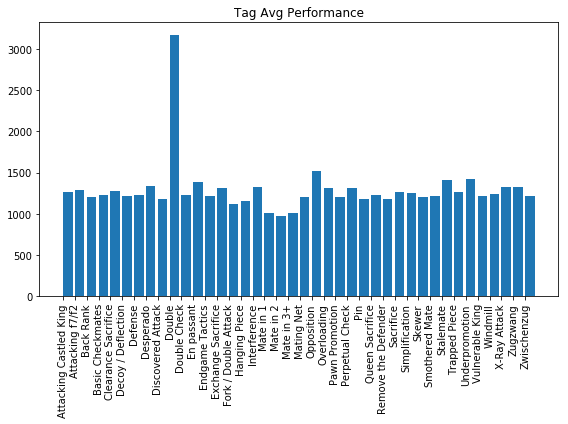

In [16]:
tag_avgs = tag_performance_user.groupby('tag').agg('mean')
plot_tag_counts(tag_avgs,'Tag Avg Performance','tag_avg_performance')

In [23]:
print('Tag Max and Min Performances')
print(max(tag_avgs))
print(min(tag_avgs))
print('---------')
print('Cluster Max and Min Performances')
print(max(cluster_avgs))
print(min(cluster_avgs))

Tag Max and Min Performances
3161.9861111111113
974.8391029022273
---------
Cluster Max and Min Performances
1541.8321925613213
636.0686723852039


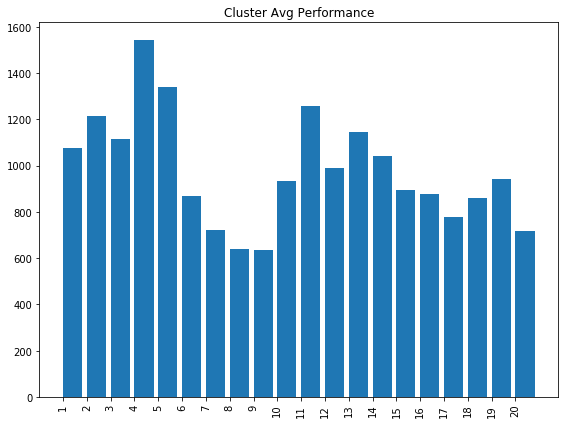

In [17]:
cluster_avgs = cluster_performance_user.groupby('cluster').agg('mean')
cluster_avgs.index = map(str, range(1,21))
plot_tag_counts(cluster_avgs,'Cluster Avg Performance','cluster_avg_performance')

<h2>Get Average User Success Sample Var in Fake Clusters</h2>

In [18]:
#Get number of puzzles in each cluster and create a numpy array of cluster labels so that the number of labels
#for cluster 'a' correspond to the count of cluster a in the original puzzle metadata
cluster_count = puzzle_data.groupby('cluster')['tactics_problem_id'].nunique().values
cluster_list = np.array([])
for i in range(20):
    clust_labels = np.full(cluster_count[i],i+1)
    cluster_list = np.append(cluster_list,clust_labels)
cluster_list = cluster_list.astype(int)

In [19]:
#Shuffle the order of the rows of the original puzzle metadata
puzzle_data_shuffled = puzzle_data.copy().sample(frac=1).reset_index(drop=True)
#Add the clusters to the shuffled puzzles so that the mismatch will create clusters of equal size as the original
#But with the puzzles grouped randomly
puzzle_data_shuffled['cluster'] = cluster_list
#Shuffle again for appearance
puzzle_data_shuffled = puzzle_data_shuffled.sample(frac=1).reset_index(drop=True)

In [20]:
puzzle_data_shuffled.head()

,tactics_problem_id,rating,rd,attempt_count,average_seconds,move_count,tags,fen,tag,cluster
0,195412,1436,45.40,60667,51,2,"Decoy / Deflection,Mate in 2,Overloading",https://lichess.org/analysis/3q4/p4R2/6pk/1p5b...,Overloading,4
1,27208,400,40.70,4764,32,1,Mate in 1,https://lichess.org/analysis/6k1/2Q2pp1/2P1p3/...,Mate in 1,8
2,40598,1525,45.02,51597,46,2,"Decoy / Deflection,Discovered Attack,Mate in 3...",https://lichess.org/analysis/r4qr1/1p2pp1k/3p3...,Discovered Attack,9
3,40677,1009,45.42,62078,57,1,Attacking Castled King,https://lichess.org/analysis/1rr3k1/3bpp1p/3p2...,Attacking Castled King,17
4,46937,686,43.48,45008,34,1,"Hanging Piece,Pin",https://lichess.org/analysis/6k1/5p2/1p6/1P4p1...,Pin,14


In [21]:
#Loop that recreates random baseline clusters and recomputes the average variance of player skills in each cluster
results = []
for i in tqdm(range(3)):
    puzzle_data_shuffled = puzzle_data.copy().sample(frac=1).reset_index(drop=True)
    puzzle_data_shuffled['cluster'] = cluster_list
    attempts.drop(['cluster'],axis=1,inplace=True)
    attempts=pd.merge(attempts,
                      puzzle_data_shuffled[['tactics_problem_id','cluster']],
                      on='tactics_problem_id', 
                      how='inner')
    #Get variance of performance rating per cluster per user
    performance_user = calc_user_performance()
    avg_cluster_variance = performance_user.var(level=0).agg('mean')
    print(avg_cluster_variance)
    results.append(avg_cluster_variance)

38767.70463934681
37558.122179808284
37694.21553551763



In [25]:
print(min(results))
print(sum(results)/3)
print(max(results))

37558.122179808284
38006.680784890916
38767.70463934681
